In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback

In [3]:
df = pd.read_csv('datasets/HousingData.csv')

In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [5]:
df_cleaned = df.dropna()
df_cleaned

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.17783,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5
500,0.22438,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6,391,19.2,396.90,14.33,16.8
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


In [6]:
X = df_cleaned.drop(columns=['MEDV'])
y = df_cleaned['MEDV']

In [7]:
X = df_cleaned.drop(columns=['MEDV'])
y = df_cleaned['MEDV']
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.15, random_state=42)

In [8]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
361,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24,666,20.2,350.65,14.19
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
62,0.11027,25.0,5.13,0.0,0.453,6.456,67.8,7.2255,8,284,19.7,396.90,6.73
469,13.07510,0.0,18.10,0.0,0.580,5.713,56.7,2.8237,24,666,20.2,396.90,14.76
267,0.57834,20.0,3.97,0.0,0.575,8.297,67.0,2.4216,5,264,13.0,384.54,7.44


In [9]:
y_train.head()

361    19.9
7      27.1
62     22.2
469    20.1
267    50.0
Name: MEDV, dtype: float64

In [10]:
mm  = MinMaxScaler()
mm.fit(X_train)
X_train = mm.transform(X_train)
X_val = mm.transform(X_val)
X_test = mm.transform(X_test)

In [11]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_val shape:', X_val.shape)

X_train shape: (267, 13)
X_test shape: (79, 13)
X_val shape: (48, 13)


In [79]:
class ReduceLRAndEarlyStop(Callback):
    def __init__(self, init_lr=10, train_loss_patience=100, val_mape_patience=float('inf'), increase_lr=False):
        super(ReduceLRAndEarlyStop, self).__init__()
        self.init_lr = init_lr
        self.best_val_mape = float('inf')
        self.last_loss = float('inf')
        self.last_val_mape = float('inf')
        self.selected_model_training_loss = None
        self.early_stop_train_loss_patience = train_loss_patience  # Patience for early stopping
        self.early_stop_train_loss_counter = 0  # Counter for early stopping
        self.early_stop_val_mape_patience = val_mape_patience
        self.early_stop_val_mape_counter = 0
        self.penalty = 0
        self.incentive = 0
        self.best_epoch = 0  # Track the best epoch
        self.best_weights = None  # Track the best weights
        self.consecutive_loss_decrement_count = -1
        self.increase_lr = increase_lr

    def early_stop(self, epoch):
        print(f'\nEarly stopping triggered at epoch {epoch+1}!')
        self.model.stop_training = True
        print(f'Restoring model weights from epoch {self.best_epoch+1}')
        print(f'Selected model training loss: {self.selected_model_training_loss}')
        print(f'Selected model validation MAPE: {self.best_val_mape} %')
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)  # Restore the best weights
        return
    
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return
        diff_loss = current_loss - self.last_loss
        self.last_loss = current_loss
        if abs(diff_loss) < 0.001:
            self.early_stop_train_loss_counter += 1
            if self.early_stop_train_loss_counter >= self.early_stop_train_loss_patience:
                self.early_stop(epoch)
        else:
            if diff_loss > 0:
                lr = self.model.optimizer.learning_rate.numpy()
                self.early_stop_train_loss_counter = 0
                self.early_stop_val_mape_counter = 0
                self.consecutive_loss_decrement_count = -1
                self.penalty += 0.05
                new_lr = lr/(1+self.penalty+self.incentive)
                self.incentive = 0
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f'\nReducing learning rate to {new_lr}')
            else:
                self.consecutive_loss_decrement_count += 1
                self.penalty = 0
                if self.consecutive_loss_decrement_count >= 10 and self.increase_lr:
                    lr = self.model.optimizer.learning_rate.numpy()
                    self.incentive += 0.05
                    new_lr = lr * (1+self.incentive)
                    self.model.optimizer.learning_rate.assign(new_lr)
                    self.consecutive_loss_decrement_count = -1
                    print(f'\nIncreasing learning rate to {new_lr}')
        current_val_mape = logs.get('val_mean_absolute_percentage_error')
        if current_val_mape is not None:
            diff_val_mape = self.last_val_mape - current_val_mape
            self.last_val_mape = current_val_mape
            lr = self.model.optimizer.learning_rate.numpy()
            if diff_val_mape > lr/10000:
                self.early_stop_val_mape_counter = 0
                if current_val_mape < self.best_val_mape:
                    self.best_val_mape = current_val_mape
                    self.best_epoch = epoch
                    self.best_weights = self.model.get_weights()
                    self.selected_model_training_loss = current_loss
            elif self.penalty == 0:
                self.early_stop_val_mape_counter += 1
                if self.early_stop_val_mape_counter >= self.early_stop_val_mape_patience:
                    self.early_stop(epoch)
        if epoch == self.params['epochs']-1:
            print(f'Selected model training loss: {self.selected_model_training_loss}')
            print(f'Selected model validation MAPE: {self.best_val_mape} %')


In [80]:
reduce_lr_early_stop_callback = ReduceLRAndEarlyStop(init_lr=0.01, train_loss_patience=100, increase_lr=True)
model = tf.keras.Sequential([
    tf.keras.Input(shape= (X_train.shape[1],) ),
    tf.keras.layers.Dense(units=1, activation='relu')  # Output layer with 1 neuron (for regression)
])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['mean_absolute_percentage_error'])
history = model.fit(X_train,y_train,validation_data=(X_val, y_val), validation_batch_size=10000,
        callbacks=[reduce_lr_early_stop_callback],verbose=2,epochs=10000, batch_size=10000)

Epoch 1/10000
1/1 - 2s - 2s/step - loss: 21.7430 - mean_absolute_percentage_error: 95.7824 - val_loss: 23.2986 - val_mean_absolute_percentage_error: 96.6500
Epoch 2/10000
1/1 - 0s - 82ms/step - loss: 21.7055 - mean_absolute_percentage_error: 95.5740 - val_loss: 23.2626 - val_mean_absolute_percentage_error: 96.4774
Epoch 3/10000
1/1 - 0s - 154ms/step - loss: 21.6680 - mean_absolute_percentage_error: 95.3657 - val_loss: 23.2266 - val_mean_absolute_percentage_error: 96.3048
Epoch 4/10000
1/1 - 0s - 82ms/step - loss: 21.6304 - mean_absolute_percentage_error: 95.1573 - val_loss: 23.1906 - val_mean_absolute_percentage_error: 96.1322
Epoch 5/10000
1/1 - 0s - 73ms/step - loss: 21.5929 - mean_absolute_percentage_error: 94.9490 - val_loss: 23.1546 - val_mean_absolute_percentage_error: 95.9596
Epoch 6/10000
1/1 - 0s - 70ms/step - loss: 21.5553 - mean_absolute_percentage_error: 94.7406 - val_loss: 23.1186 - val_mean_absolute_percentage_error: 95.7870
Epoch 7/10000
1/1 - 0s - 79ms/step - loss: 21.5

In [81]:
y_pred = model.predict(X_test, verbose=0)
loss, mape = model.evaluate(X_test, y_test, verbose=0) # this will return the error metric defined in model.compile's loss option. i-e: loss='mean_absolute_error'
# Compute the R^2 score
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
print('Loss (Mean absolute error per testing example):', loss)
print('MAPE (Mean absolute percentage error per testing example):', mape)

R2 score: 0.6035031560074666
Loss (Mean absolute error per testing example): 3.792649745941162
MAPE (Mean absolute percentage error per testing example): 18.299823760986328


#### Plotting Predicted vs Actual Value of Linear Regression Model

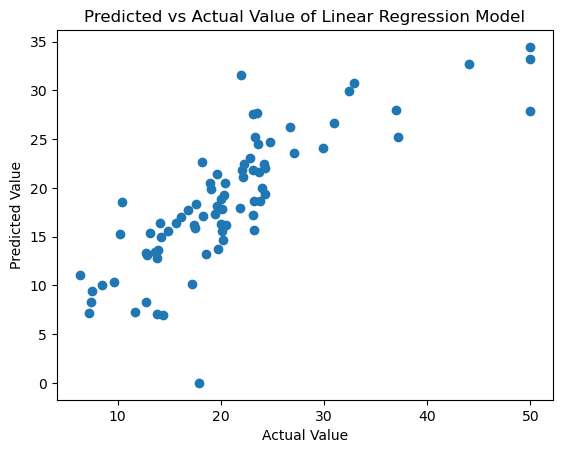

In [73]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs Actual Value of Linear Regression Model')
plt.show()

In [59]:
historydf = pd.DataFrame(history.history)
historydf

,loss,mean_absolute_percentage_error,val_loss,val_mean_absolute_percentage_error
0,22.301136,99.005325,23.661661,98.571144
1,22.267241,98.820938,23.627645,98.411247
2,22.231941,98.628387,23.592367,98.242340
3,22.195835,98.429909,23.556795,98.072021
4,22.159122,98.227364,23.520945,97.900269
...,...,...,...,...
565,3.032962,14.859996,2.677712,14.226685
566,3.032365,14.839553,2.681729,14.240573
567,3.031823,14.851417,2.681115,14.238529
568,3.031270,14.848709,2.680500,14.236484


In [186]:
historydf['val_mean_absolute_percentage_error'].min()

12.299099922180176

Text(0.5, 1.0, 'Error Comparison')

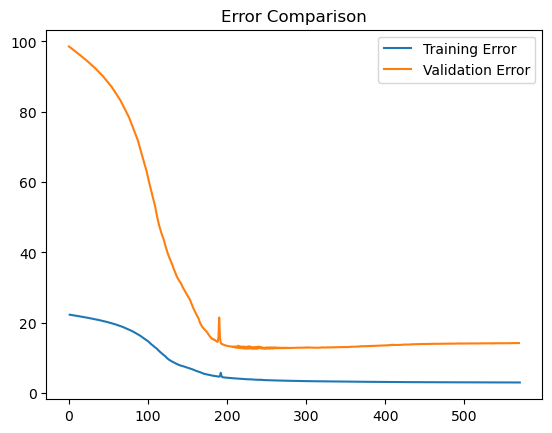

In [61]:
import numpy as np
x = np.arange(1, historydf.shape[0]+1)
plt.plot(x, historydf[['loss']], historydf[['val_mean_absolute_percentage_error']])
plt.legend(['Training Error', 'Validation Error'])
plt.title('Error Comparison')

In [13]:
def generate_combinations(arr, r):
    # Helper function to generate combinations
    def backtrack(start, path):
        # If the combination is of length r, add it to the result
        if len(path) == r:
            result.append(path[:])
            return
        for i in range(start, len(arr)):
            # Add the current element and recurse
            path.append(arr[i])
            backtrack(i, path)
            path.pop()  # Backtrack

    arr.sort(reverse=True)  # Ensure the array is sorted in descending order
    result = []
    backtrack(0, [])
    return result

In [ ]:
class RestoreBestWeights(Callback):
    def __init__(self, monitor):
        super(RestoreBestWeights, self).__init__()
        self.best_val = float('inf')
        self.monitor = monitor
        self.best_epoch = None
        self.best_weights = None
        self.final_model_training_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get(self.monitor)
        if current_val < self.best_val:
            self.best_val = current_val
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
            self.final_model_training_loss = logs.get('loss')
        if epoch == self.params['epochs']-1:
            self.model.set_weights(self.best_weights)
            print(f'\nRestoring Best Weights From Epoch: {self.best_epoch+1}\n')
            print(f'Selected model {self.monitor}: {self.best_val}')
            print(f'Selected model training loss: {self.final_model_training_loss}\n')

In [36]:
def model_selector(X_train, y_train, X_val, y_val, min_hidden_layers, max_hidden_layers, min_neurons, max_neurons, neuron_step, total_features, total_outputs):
    trial_count = 0
    neuron_choices = [i for i in range(min_neurons, max_neurons+1, neuron_step)]
    models = []
    for layer in range(min_hidden_layers, max_hidden_layers+1):
        # neuron_combinations = generate_combinations(neuron_choices, layer)
        neuron_combinations = [ [24,16], [22,16], [20,16] ]
        neuron_combination_idx = 0
        while neuron_combination_idx < len(neuron_combinations):
            model = tf.keras.Sequential()
            model.add(tf.keras.Input(shape=(total_features,)))
            for neuron in neuron_combinations[neuron_combination_idx]:
                model.add(tf.keras.layers.Dense(units=neuron, activation='relu'))
            trial_count +=1
            print(f'Trial {trial_count}\n')
            print(f'Total layers: {layer}')
            print(f'Neurons combination: {neuron_combinations[neuron_combination_idx]}\n')
            model.add(tf.keras.layers.Dense(total_outputs, ))
            monitor = RestoreBestWeights(monitor='val_mean_absolute_percentage_error')
            model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mean_absolute_percentage_error'])
            history = model.fit(X_train,y_train,validation_data=(X_val,y_val),callbacks=[monitor], verbose=2, epochs=100, batch_size=128)
            historydf = pd.DataFrame(history.history)
            if historydf['val_loss'].std() == 0:
                print('Trial failed. Retrying!\n')
                neuron_combination_idx -= 1
                continue
            test_loss, test_mape = model.evaluate(X_test, y_test, verbose=0)
            val_loss, val_mape = model.evaluate(X_val, y_val, verbose=0)
            training_loss, training_mape = model.evaluate(X_train, y_train, verbose=0)
            hidden_layers = len(model.layers)-1
            hidden_layer_neurons = []
            for i in range(0, hidden_layers):
                hidden_layer_neurons.append(model.layers[i].units)
            models.append({
                'model': model,
                'hidden_layers': hidden_layers,
                'hidden_layer_neurons': hidden_layer_neurons,
                'val_mape': val_mape,
                'test_mape': test_mape,
                'training_loss': training_loss,
                'test_loss': test_loss,
                'val_loss': val_loss
            })
            neuron_combination_idx += 1
    models = sorted(models, key=lambda x: x['val_mape'])
    return models


In [37]:
models = model_selector(
    X_train,
    y_train,
    X_val,
    y_val,
    min_hidden_layers=1,
    max_hidden_layers=2,
    min_neurons=8,
    max_neurons=32,
    neuron_step=8,
    total_features=X_train.shape[1],
    total_outputs=1
)

Trial 1

Total layers: 1
Neurons combination: [32]

Epoch 1/10000
1/1 - 1s - 1s/step - loss: 22.8463 - mean_absolute_percentage_error: 101.7382 - val_loss: 24.2012 - val_mean_absolute_percentage_error: 100.8624
Epoch 2/10000
1/1 - 0s - 83ms/step - loss: 22.7615 - mean_absolute_percentage_error: 101.2736 - val_loss: 24.1193 - val_mean_absolute_percentage_error: 100.4734
Epoch 3/10000
1/1 - 0s - 70ms/step - loss: 22.6771 - mean_absolute_percentage_error: 100.8117 - val_loss: 24.0379 - val_mean_absolute_percentage_error: 100.0871
Epoch 4/10000
1/1 - 0s - 79ms/step - loss: 22.5933 - mean_absolute_percentage_error: 100.3532 - val_loss: 23.9570 - val_mean_absolute_percentage_error: 99.7028
Epoch 5/10000
1/1 - 0s - 81ms/step - loss: 22.5101 - mean_absolute_percentage_error: 99.8976 - val_loss: 23.8762 - val_mean_absolute_percentage_error: 99.3188
Epoch 6/10000
1/1 - 0s - 100ms/step - loss: 22.4272 - mean_absolute_percentage_error: 99.4437 - val_loss: 23.7951 - val_mean_absolute_percentage_err

In [58]:
models

[{'model': <Sequential name=sequential_34, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [32, 24],
  'val_mape': 10.413269996643066,
  'test_mape': 17.529102325439453,
  'training_loss': 3.4890658855438232,
  'test_loss': 3.6565003395080566,
  'val_loss': 2.271151542663574},
 {'model': <Sequential name=sequential_33, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [32, 32],
  'val_mape': 10.60788345336914,
  'test_mape': 17.77292823791504,
  'training_loss': 3.709991455078125,
  'test_loss': 3.6337485313415527,
  'val_loss': 2.3560802936553955},
 {'model': <Sequential name=sequential_39, built=True>,
  'hidden_layers': 2,
  'hidden_layer_neurons': [24, 8],
  'val_mape': 10.643752098083496,
  'test_mape': 17.455087661743164,
  'training_loss': 3.7198402881622314,
  'test_loss': 3.650813341140747,
  'val_loss': 2.3938076496124268},
 {'model': <Sequential name=sequential_32, built=True>,
  'hidden_layers': 1,
  'hidden_layer_neurons': [8],
  'val_mape': 11.0310